# [Peer Read Dataset](https://github.com/allenai/PeerRead)
Data and code for Kang et al., NAACL 2018's paper titled "A Dataset of Peer Reviews (PeerRead): Collection, Insights and NLP Applications"

# You can find the final gathered dataset here [CSV File Link](https://drive.google.com/file/d/1xyMOacZPiG-vs9EwGJSdoe2lo5c1yC-z/view?usp=sharing)

# **Phase 1: Data Ingestion and Preprocessing**
* **First, we establish the environment and retrieve the dataset from Kaggle.**

## **1. Environment Setup & Data Import**

In [ ]:
import kagglehub
import os
import json
import glob
import pandas as pd
import numpy as np

try:
    jonauskis_asap_review_path = kagglehub.dataset_download('jonauskis/asap-review')
    print('Data source import complete.')
except Exception as e:
    print(f"Error downloading data: {e}")

def folder_details(path):
    if os.path.exists(path):
        folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
        print(f"Directory: {path}\nNumber of folders: {len(folders)}")
    else:
        print(f"Path not found: {path}")

def json_details_viewer(base_path):
    json_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".json"):
                json_files.append(os.path.join(root, file))

    print(f"Total JSON files found in {base_path}: {len(json_files)}")
    if json_files:
        with open(json_files[0], "r", encoding="utf-8") as f:
            data = json.load(f)
        print("Sample file top-level keys:", list(data.keys()))

base_dir = "/kaggle/input/asap-review"
folder_details(base_dir)

100%|██████████| 225M/225M [00:11<00:00, 20.7MB/s]

Extracting files...


Data source import complete.
Path not found: /kaggle/input/asap-review


## **2. Data Extraction and Compilation**

In [ ]:
all_papers_data = []
journal_dirs = glob.glob(os.path.join(base_dir, "*"))

print(f"Found {len(journal_dirs)} journal directories. Starting processing...")

for journal_path in journal_dirs:
    if not os.path.isdir(journal_path): continue

    journal_name = os.path.basename(journal_path)
    content_dir = os.path.join(journal_path, f"{journal_name}_content")
    review_dir = os.path.join(journal_path, f"{journal_name}_review")
    content_files = glob.glob(os.path.join(content_dir, "*.json"))

    for content_file_path in content_files:
        paper_data = {}
        try:
            base_filename = os.path.basename(content_file_path)
            paper_id = base_filename.replace("_content.json", "")
            review_file_path = os.path.join(review_dir, f"{paper_id}_review.json")

            paper_data['journal'] = journal_name

            with open(content_file_path, 'r', encoding='utf-8') as f:
                content_data = json.load(f)
                paper_data['title'] = content_data.get('metadata', {}).get('title', None)
                paper_data['sections'] = content_data.get('metadata', {}).get('sections', None)

            paper_data['reviews'] = None
            if os.path.exists(review_file_path):
                with open(review_file_path, 'r', encoding='utf-8') as f:
                    review_data = json.load(f)
                    # Handle key inconsistencies
                    paper_data['reviews'] = review_data.get('reviews') or review_data.get('reveiws')

            all_papers_data.append(paper_data)

        except Exception as e:
            print(f"Error processing {base_filename}: {e}")

if all_papers_data:
    df = pd.DataFrame(all_papers_data)
    df = df[['journal', 'title', 'reviews', 'sections']].dropna(subset=['title'])
    df.to_csv("asap_dataset_compiled.csv", index=False)
    print(f"Dataset compiled: {len(df)} rows.")
    display(df.head())

Found 0 journal directories. Starting processing...


## **3. Text Preprocessing**

In [ ]:
import nltk
import ast
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def simple_preprocess_nltk(text, min_len=2, max_len=15):
    text = re.sub(r'[^a-zA-Z0-9\s\-\']', '', text)
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if min_len <= len(t) <= max_len and t not in stop_words]
    return tokens

def preprocess_column(text_list_str):
    """Parses stringified lists and tokenizes content."""
    try:
        text_list = ast.literal_eval(text_list_str)
    except (ValueError, SyntaxError):
        return []

    processed_tokens = []
    if isinstance(text_list, list):
        for item in text_list:
            # Handle different key names in JSON structure
            text_content = item.get('review') or item.get('text')
            if text_content:
                processed_tokens.extend(simple_preprocess_nltk(text_content))

    return processed_tokens

df['reviews_tokens'] = df['reviews'].apply(lambda x: preprocess_column(str(x)))
df['sections_tokens'] = df['sections'].apply(lambda x: preprocess_column(str(x)))

df['reviews_text'] = df['reviews_tokens'].apply(lambda x: " ".join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NameError: name 'df' is not defined

## **4. Exploratory Data Analysis (EDA)**

In [ ]:
import matplotlib.pyplot as plt

df['reviews_length'] = df['reviews_tokens'].apply(len)
df['sections_length'] = df['sections_tokens'].apply(len)

print("Review Length Stats:"); display(df['reviews_length'].describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['reviews_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')

plt.subplot(1, 2, 2)
plt.hist(df['sections_length'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Section Lengths')
plt.tight_layout()
plt.show()

# **Phase 2: Feature Engineering & Embeddings**
* **We apply various vectorization techniques to transform text into numerical representations suitable for machine learning.**

## **1. TF-IDF & Visualization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Vectorization
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df['reviews_text'])
feature_names = vectorizer.get_feature_names_out()

# T-SNE Visualization of Terms
term_vecs = vectorizer.transform(feature_names).toarray()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
tsne_emb = tsne.fit_transform(term_vecs)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c='darkgreen', alpha=0.6)
for i, term in enumerate(feature_names[:50]): # Label first 50 for clarity
    plt.annotate(term, (tsne_emb[i,0], tsne_emb[i,1]), fontsize=9)
plt.title('t-SNE: TF-IDF Word Vectors')
plt.show()

## **2. Word2Vec**

In [ ]:
from gensim.models import Word2Vec

sentences = df['reviews_tokens'].tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

print("Word2Vec Training Complete. Vocabulary Size:", len(w2v_model.wv.key_to_index))

## **3. Contextual Embeddings (BERT)**
Using pre-trained Sentence-BERT for state-of-the-art context awareness.

In [ ]:
from sentence_transformers import SentenceTransformer

# Load Pre-trained Model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode Reviews (Subset for demonstration if dataset is large)
subset_sentences = [" ".join(tokens) for tokens in df['reviews_tokens'][:500]]
bert_embeddings = sbert_model.encode(subset_sentences, show_progress_bar=True)

print(f"BERT Embeddings Shape: {bert_embeddings.shape}")

## **4. GloVe**

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-100")

In [ ]:
print("GloVe loaded. Vocabulary size:", len(glove_model.key_to_index))

In [ ]:
all_tokens = [token for doc_tokens in df['reviews_tokens'] for token in doc_tokens]
vocab_in_data = list(set(all_tokens))

In [ ]:
words = [w for w in vocab_in_data if w in glove_model.key_to_index][:200]
vectors = np.array([glove_model[w] for w in words])

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words)-1), init='pca')
tsne_emb = tsne.fit_transform(vectors)

plt.figure(figsize=(12,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], color='purple', alpha=0.7)
for i,w in enumerate(words):
    plt.annotate(w, (tsne_emb[i,0], tsne_emb[i,1]), fontsize=8)
plt.title('t-SNE: GloVe on Tokens')
plt.grid(True); plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(vectors)
plt.figure(figsize=(12,10))
plt.scatter(pca_emb[:,0], pca_emb[:,1], color='orange', alpha=0.7)
for i,w in enumerate(words):
    plt.annotate(w, (pca_emb[i,0], pca_emb[i,1]), fontsize=8)
plt.title('PCA: GloVe on Tokens')
plt.grid(True); plt.show()

## **5. FastText**

In [ ]:
sentences = df['reviews_tokens'].tolist()

print("Training FastText on your tokens...")
fasttext_model = FastText(
    sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0,
    epochs=10
)
print("Done. Vocab size:", len(fasttext_model.wv.key_to_index))

In [ ]:
vocab = list(fasttext_model.wv.key_to_index.keys())
vectors = np.array([fasttext_model.wv[w] for w in vocab])

subset_words = vocab[:200]
subset_vectors = vectors[:200]

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
tsne_emb = tsne.fit_transform(subset_vectors)
plt.figure(figsize=(12,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], color='magenta', alpha=0.7)
for i,w in enumerate(subset_words):
    plt.annotate(w, (tsne_emb[i,0], tsne_emb[i,1]), fontsize=8)
plt.title('t-SNE: FastText trained on  tokens)')
plt.grid(True); plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(subset_vectors)
plt.figure(figsize=(12,10))
plt.scatter(pca_emb[:,0], pca_emb[:,1], color='lime', alpha=0.7)
for i,w in enumerate(subset_words):
    plt.annotate(w, (pca_emb[i,0], pca_emb[i,1]), fontsize=8)
plt.title('PCA: FastText trained on tokens)')
plt.grid(True); plt.show()

# **Phase 3: Section Classification (Deep Learning)**
* **The goal of this phase is to classify text segments into standard academic paper sections (e.g., Introduction, Methodology, Experiments).**

## **1. Data Transformation & Labeling**
We normalize diverse section headers into standard categories.

In [ ]:
def normalize_section_label(header):
    if not isinstance(header, str): return "Unknown"
    clean = re.sub(r'^[\d\.\s]+', '', header).lower().strip()

    mapping = {
        'Appendix': ['acknowledgement', 'appendix', 'reference'],
        'Introduction': ['introduction', 'motivation', 'preface'],
        'Conclusion': ['conclusion', 'summary', 'future work', 'discussion'],
        'Related Work': ['related work', 'background', 'literature', 'prior work'],
        'Experiments': ['experiment', 'result', 'evaluation', 'performance', 'dataset'],
        'Methodology': [] # Default/Fallthrough
    }

    for label, keywords in mapping.items():
        pattern = r'\b(' + '|'.join(keywords) + r')\b'
        if keywords and re.search(pattern, clean):
            return label
    return 'Methodology'

# Extract and Flatten Sections
flat_data = []
for idx, row in df.iterrows():
    try:
        sections = ast.literal_eval(row['sections'])
        if isinstance(sections, list):
            for s in sections:
                if s.get('text'):
                    flat_data.append({
                        'text': s['text'],
                        'raw_label': s.get('heading', ''),
                        'label': normalize_section_label(s.get('heading', ''))
                    })
    except: continue

section_df = pd.DataFrame(flat_data)
print("Class Distribution:\n", section_df['label'].value_counts())

## **2. Class Balancing**
* **We apply undersampling and oversampling to create a balanced dataset for training.**

In [ ]:
from sklearn.utils import resample

TARGET_SIZE = 3000
balanced_dfs = []

for label in section_df['label'].unique():
    df_subset = section_df[section_df['label'] == label]

    if len(df_subset) > TARGET_SIZE:
        # Undersample
        resampled = resample(df_subset, replace=False, n_samples=TARGET_SIZE, random_state=42)
    else:
        # Oversample
        resampled = resample(df_subset, replace=True, n_samples=TARGET_SIZE, random_state=42)

    balanced_dfs.append(resampled)

final_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Balanced Dataset Size: {len(final_df)}")

## **3. Deep Learning Architectures**

* We prepare the data for Keras and define multiple architectures (LSTM, CNN-BiLSTM).

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input , GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report , accuracy_score, precision_recall_fscore_support

In [ ]:
# Preparation
X = final_df['text'].astype(str)
y = final_df['label']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Tokenization
MAX_WORDS = 20000
MAX_LEN = 300
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, padding='post')

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post")

## **3.1. Trials for section detection problem across different architectures**

In [ ]:
# --- Model 1: Bi-Directional LSTM ---
model_bilstm = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
model_bilstm.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bilstm.summary()

In [ ]:
# --- Model 2: CNN + BiLSTM Hybrid ---
model_hybrid = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
model_hybrid.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_hybrid.summary()

In [ ]:
# --- Model 3: LSTM ---
model_lstm = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    LSTM(128),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_lstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print(model_lstm.summary())

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_lstm_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

y_pred_lstm = model_lstm.predict(X_test_pad).argmax(axis=1)
print(classification_report(y_test, y_pred_lstm, target_names=encoder.classes_))

In [ ]:
# --- Model 4: GRU ---
model_gru = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    GRU(128),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_gru.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_gru.summary()

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
]

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

history_cnn_bilstm = model_hybrid.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

history_gru = model_gru.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

## **3.2. Analysis for the training results from different DL Architectures**

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=1)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro"
    )

    return acc, precision, recall, f1

# Collect results
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

models = {
    "LSTM": model_lstm,
    "BiLSTM": model_bilstm,
    "CNN-BiLSTM": model_hybrid,
    "GRU": model_gru
}

for model_name, model in models.items():
    acc, pr, re, f1 = evaluate_model(model, X_test_pad, y_test)
    results["Model"].append(model_name)
    results["Accuracy"].append(acc)
    results["Precision"].append(pr)
    results["Recall"].append(re)
    results["F1-Score"].append(f1)

df_results = pd.DataFrame(results)
df_results

In [ ]:
def plot_training_history(history, title):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_lstm, "LSTM")
plot_training_history(history_bilstm, "BiLSTM")
plot_training_history(history_cnn_bilstm, "CNN-BiLSTM")
plot_training_history(history_gru, "GRU")

In [ ]:
plot_styles = {
    "LSTM": {'color':'blue', 'marker':'o', 'linestyle':'-'},
    "BiLSTM": {'color':'green', 'marker':'s', 'linestyle':'--'},
    "CNN-BiLSTM": {'color':'red', 'marker':'^', 'linestyle':'-.'},
    "GRU": {'color':'purple', 'marker':'d', 'linestyle':':'}
}

# Accuracy figure
plt.figure(figsize=(10,5))
for name, history in df_results.items():
    plt.plot(
        history.history['val_accuracy'],
        label=f"{name} - Val Accuracy",
        **plot_styles[name]
    )
    # Add markers at each epoch
    plt.scatter(
        range(len(history.history['val_accuracy'])),
        history.history['val_accuracy'],
        color=plot_styles[name]['color']
    )
plt.title("Validation Accuracy Across Models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(history_lstm.history['val_accuracy'])), range(1, len(history_lstm.history['val_accuracy'])+1))
plt.legend()
plt.grid(True)
plt.show()

# Loss figure
plt.figure(figsize=(10,5))
for name, history in df_results.items():
    plt.plot(
        history.history['val_loss'],
        label=f"{name} - Val Loss",
        **plot_styles[name]
    )
    # Add markers at each epoch
    plt.scatter(
        range(len(history.history['val_loss'])),
        history.history['val_loss'],
        color=plot_styles[name]['color']
    )
plt.title("Validation Loss Across Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(history_lstm.history['val_loss'])), range(1, len(history_lstm.history['val_loss'])+1))
plt.legend()
plt.grid(True)
plt.show()

# **Phase 4: Scientific Document Parsing (OCR)**

* **While the previous phases analyzed pre-extracted text, real-world research workflows often start with raw PDFs or scanned images. Standard PDF parsers struggle with complex academic layouts, mathematical formulas, and tables. In this phase, we utilize Nougat (Neural Optical Understanding for Academic Documents), a Transformer model by Meta, to transcribe visual documents directly into lightweight Markdown and LaTeX formats.**

## **1. System Setup & Dependencies**

In [1]:
# Install Python dependencies
!pip install transformers torch pillow pdf2image python-Levenshtein

# Install System dependencies (Linux/Colab)
!sudo apt-get install poppler-utils

print("Dependencies installed successfully.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Dependencies installed successfully.


## **2. Document Conversion Pipeline**

In [2]:
import os
import re
import pandas
import torch
from PIL import Image
from pdf2image import convert_from_path
from transformers import NougatProcessor, VisionEncoderDecoderModel

In [3]:
def convert_to_latex(file_path, out_name="output.mmd"):
    """
    Converts a PDF or Image file to Markdown/LaTeX using the Nougat model.
    """
    model_tag = "facebook/nougat-base"

    print(f"Loading model: {model_tag}...")
    processor = NougatProcessor.from_pretrained(model_tag)
    model = VisionEncoderDecoderModel.from_pretrained(model_tag)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print(f"Using device: {device}")

    images = []
    if file_path.lower().endswith(".pdf"):
        print("Rendering PDF pages to images...")
        images = convert_from_path(file_path)
    else:
        try:
            print("Loading image file...")
            images = [Image.open(file_path).convert("RGB")]
        except Exception as e:
            print(f"Error loading file: {e}")
            return

    full_text = ""
    print(f"Processing {len(images)} page(s). This may take a while on CPU...")

    for i, img in enumerate(images):
        pixel_values = processor(img, return_tensors="pt").pixel_values.to(device)
        outputs = model.generate(
            pixel_values,
            min_length=1,
            max_new_tokens=4000,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
        )

        seq = processor.batch_decode(outputs, skip_special_tokens=True)[0]
        seq = processor.post_process_generation(seq, fix_markdown=False)

        full_text += f"\n% Page {i+1}\n{seq}\n"
        print(f"Page {i+1} complete.")

    with open(out_name, "w", encoding="utf-8") as f:
        f.write(full_text)

    print(f"Conversion complete. Saved to: {out_name}")

In [4]:
def parse_mmd_to_sections(mmd_content):
    """
    Parses Nougat Markdown output into a list of dictionaries
    matching the 'sections' column structure from Phase 1.
    """
    lines = mmd_content.split('\n')
    sections = []
    current_heading = "Abstract"
    current_text = []

    header_pattern = re.compile(r'^(#+)\s+(.*)')

    for line in lines:
        match = header_pattern.match(line)
        if match:
            if current_text:
                sections.append({
                    'heading': current_heading,
                    'text': ' '.join(current_text).strip()
                })
            current_heading = match.group(2).strip()
            current_text = []
        else:
            if not line.strip().startswith('% Page') and line.strip():
                current_text.append(line.strip())

    if current_text:
        sections.append({
            'heading': current_heading,
            'text': ' '.join(current_text).strip()
        })

    return sections  # Fixed: was returning 'section' instead of 'sections'

In [15]:
target_file = "/content/Gemini_Generated_Image_32yraj32yraj32yr.png"

if os.path.exists(target_file):
    convert_to_latex(target_file)
else:
    print(f"File not found: {target_file}")

try:
    with open("output.mmd", "r", encoding="utf-8") as f:
        mmd_data = f.read()

    parsed_sections = parse_mmd_to_sections(mmd_data)

    new_paper_row = {
        'journal': 'Uploaded_File',
        'title': 'Extracted Paper',
        'reviews': [],
        'sections': str(parsed_sections),
        'sections_list': parsed_sections
    }

    df_new = pd.DataFrame([new_paper_row])

    print("Parsed Data Structure:")
    display(df_new.head())

    print(f"\nFirst Section Detected: {parsed_sections[0]['heading']}")
    print(f"Content Preview: {parsed_sections[0]['text'][:200]}...")

except FileNotFoundError:
    print("output.mmd not found. Please run Phase 4 first.")

File not found: /content/Gemini_Generated_Image_32yraj32yraj32yr.png
output.mmd not found. Please run Phase 4 first.


In [ ]:
texts_to_predict = [s['text'] for s in parsed_sections]
headings = [s['heading'] for s in parsed_sections]

seqs = tokenizer.texts_to_sequences(texts_to_predict)
padded_seqs = pad_sequences(seqs, maxlen=MAX_LEN, padding='post')

predictions = model_hybrid.predict(padded_seqs)
predicted_indices = predictions.argmax(axis=1)
predicted_labels = encoder.inverse_transform(predicted_indices)

results_df = pd.DataFrame({
    'Original Heading': headings,
    'Predicted Label': predicted_labels,
    'Confidence': [max(p) for p in predictions]
})

print("\n--- Section Classification Results ---")
display(results_df)

# **Phase 5.0**


```
def corrupt_scientific_text(text):
    words = text.split()
    if len(words) < 6:
        return text

    i = random.randint(1, len(words) - 2)
    noise = random.choice([
        lambda w: w[:-1],           # deletion
        lambda w: w + "s",          # plural noise
        lambda w: w.replace("the", "")
    ])

    words[i] = noise(words[i])
    return " ".join(words)
```



# **Phase 5: Automated Grammar Correction(GEC)**

* **Objective: Build a robust Grammar Error Correction (GEC) pipeline to clean OCR outputs (from Phase 4) and noisy peer-review text.Approach: We fine-tune a T5-base model on the JFLEG dataset. Unlike simple implementations, we utilize multi-reference supervision (selecting random valid corrections during training) and evaluate using GLEU (Google-BLEU), the standard metric for grammatical fluency.**

## **1. Setup and Model Initialization**

In [ ]:
# Install required libraries
!pip install -q transformers datasets evaluate sentencepiece sacrebleu accelerate

In [ ]:
import torch
import random
import pandas as pd
from datasets import load_dataset
from transformers import (
    T5TokenizerFast,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments ,
    EarlyStoppingCallback
)
import evaluate

# Check Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device.upper()}")

## **2. Data Loading & Preprocessing (Multi-Reference)**
* **The JFLEG dataset contains multiple valid corrections for each bad sentence. To make our model robust, we randomly select one valid correction as the target during each training epoch.**

In [ ]:
raw_train = load_dataset("jfleg", split="validation")
raw_eval  = load_dataset("jfleg", split="test")

model_name = "t5-base"
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)

MAX_INPUT_LEN  = 256
MAX_TARGET_LEN = 256

def preprocess_multi_ref(example):
    """
    Tokenizes inputs and targets.
    Strategy: Randomly selects one valid correction from the list
    to provide varied supervision signals.
    """
    input_text = "grammar: " + example["sentence"]
    target_text = random.choice(example["corrections"])

    model_inputs = tokenizer(
        input_text,
        max_length=MAX_INPUT_LEN,
        truncation=True
    )

    labels = tokenizer(
        target_text,
        max_length=MAX_TARGET_LEN,
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = raw_train.map(preprocess_multi_ref, remove_columns=raw_train.column_names)
eval_dataset = raw_eval.map(preprocess_multi_ref, remove_columns=raw_eval.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

print("Data preprocessing complete.")

## **3. Metrics & Training Configuration**

In [ ]:
gleu = evaluate.load("google_bleu")
import numpy as np
import torch

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple) or preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    preds = preds.astype(np.int32)
    labels = labels.astype(np.int32)

    decoded_preds = []
    for p in preds:
        p = [int(x) for x in p if x >= 0]
        decoded_preds.append(tokenizer.decode(p, skip_special_tokens=True))

    decoded_labels = []
    for l in labels:
        l = [int(x) for x in l if x >= 0]
        decoded_labels.append(tokenizer.decode(l, skip_special_tokens=True))

    references = [[lbl.strip()] for lbl in decoded_labels]
    predictions = [pred.strip() for pred in decoded_preds]

    return gleu.compute(predictions=predictions, references=references)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-grammar",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    predict_with_generate=True,
    generation_max_length=128,
    load_best_model_at_end=True,
    metric_for_best_model="eval_google_bleu",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    report_to="none"
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

## **4. Training and Evaluation**

In [ ]:
trainer.save_model("./t5-grammar/best_model")
tokenizer.save_pretrained("./t5-grammar/best_model")

In [ ]:
print("Starting Training...")
trainer.train()

print("Evaluating Model...")
metrics = trainer.evaluate()
print(f"Final GLEU Score: {metrics['eval_google_bleu']:.4f}")

## **5. Inference & Integration (Cleaning OCR Data)**

In [ ]:
def correct_sentence(text):
    """
    Corrects grammar using the fine-tuned T5 model.
    """
    input_text = "grammar: " + text
    inputs = tokenizer(
        input_text,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        **inputs,
        num_beams=5,
        max_length=128,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
print("\n--- Standard Tests ---")
print(f"Input: 'This sentences, has bads grammar and spelling!'")
print(f"Output: {correct_sentence('This sentences, has bads grammar and spelling!')}")

print(f"\nInput: 'I am enjoys, writtings articles ons AI...'")
print(f"Output: {correct_sentence('I am enjoys, writtings articles ons AI and I also enjoyed write articling on AI.')}")

In [ ]:
# --- Integration: Cleaning OCR Output from Phase 4 ---
def correct_ocr_sections(parsed_sections, max_chars=500):
    """
    Applies grammar correction to all OCR-extracted sections.
    Returns corrected sections for downstream pipeline use.
    """
    corrected_sections = []

    print("\n" + "="*60)
    print("PHASE 5 INTEGRATION: Cleaning OCR Output")
    print("="*60)

    for i, section in enumerate(parsed_sections):
        heading = section.get('heading', 'Unknown')
        raw_text = section.get('text', '')[:max_chars]  # Limit for efficiency

        if raw_text:
            corrected_text = correct_sentence(raw_text)
            corrected_sections.append({
                'heading': heading,
                'raw_text': raw_text,
                'corrected_text': corrected_text
            })

            print(f"\n--- Section {i+1}: {heading} ---")
            print(f"RAW OCR ({len(raw_text)} chars):\n{raw_text[:150]}...")
            print(f"\nCORRECTED:\n{corrected_text[:150]}...")

    return corrected_sections

# Execute if OCR data exists
if 'parsed_sections' in locals() and parsed_sections:
    corrected_ocr_sections = correct_ocr_sections(parsed_sections)
    print(f"\n✓ Corrected {len(corrected_ocr_sections)} sections from OCR output")
else:
    print("\n⚠ No OCR data found in memory. Run Phase 4 first to see integration.")
    corrected_ocr_sections = []

In [ ]:
# !zip -r /content/folder_name.zip /content/t5-grammar

In [ ]:
# from google.colab import files
# files.download('/content/grammar_correction.zip')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/t5-grammar /content/drive/MyDrive/"NLP Weights"


# **Phase 6: Fact Checking / Consistency Alerts**
* **Build a pipeline to verify claims against evidence. This is essential for detecting hallucinations in generated text or inconsistencies in peer reviews. Dataset: FEVER (Fact Extraction and VERification). Model: T5-Small (Fine-tuned for Natural Language Inference)**

## **1. Setup and Dependencies**

In [ ]:
# 1. Install dependencies
!pip install datasets transformers tqdm

import torch
from datasets import load_dataset, Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments
)
from collections import defaultdict

# Check Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device.upper()}")

## **2. Load and Preprocess FEVER Dataset**

In [ ]:
print("Loading FEVER dataset...")
ds = load_dataset("fever", revision="refs/convert/parquet")
print(f"Loaded {len(ds)} examples.")

In [ ]:
ds['train'][1]

In [ ]:
def attach_evidence_text(example):
    example["evidence_text"] = f"Content regarding {example['evidence_wiki_url']}."
    return example

ds_with_text = ds.map(attach_evidence_text)

def aggregate_evidence(dataset):
    grouped = defaultdict(list)
    for ex in dataset:
        grouped[ex["id"]].append(ex)

    aggregated = []
    for claim_id, examples in grouped.items():
        label = examples[0]["label"]
        claim = examples[0]["claim"]

        evidence_texts = [ex["evidence_text"] for ex in examples if ex.get("evidence_text")]
        premise = " ".join(evidence_texts) if evidence_texts else "No evidence available."

        aggregated.append({
            "premise": premise,
            "hypothesis": claim,
            "label": label
        })
    return aggregated

In [ ]:
train_data = aggregate_evidence(ds_with_text["train"])
print(f"Aggregated into {len(train_data)} unique claims.")
print("Sample:", train_data[0])

## **3. Prepare Data for T5 (Text-to-Text Format)**

In [ ]:
def to_t5_format(example):
    return {
        "input_text": f"verify: {example['premise']} </s> claim: {example['hypothesis']}",
        "target_text": example["label"]
    }

formatted_ds = Dataset.from_list(train_data).map(to_t5_format)
print("Formatted Example:", formatted_ds[0])

In [ ]:
label2id = {"supports": 0, "refutes": 1, "not enough info": 2}

def encode_labels(example):
    label = example.get("label", "")
    if not label:  # skip or set default for empty labels
        example["label"] = -1  # -1 indicates "ignore" or "unlabeled"
    else:
        example["label"] = label2id[label.lower()]
    return example

train_dataset = ds_with_text["train"].map(encode_labels)
val_dataset = ds_with_text["validation"].map(encode_labels)


In [ ]:
train_dataset = train_dataset.filter(lambda x: x["label"] != -1)
val_dataset = val_dataset.filter(lambda x: x["label"] != -1)

## **4. Model Initialization & Tokenization**

In [ ]:
model_name = "t5-small"

tokenizer = T5Tokenizer.from_pretrained(model_name, legacy=False)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

def tokenize_and_prepare_labels(example):
    model_inputs = tokenizer(
        example["input_text"],
        max_length=512,
        truncation=True,
        padding="max_length",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["target_text"],
            max_length=10,
            truncation=True,
            padding="max_length",
        )

    model_inputs["labels"] = [
        (l if l != tokenizer.pad_token_id else -100) for l in labels["input_ids"]
    ]
    return model_inputs

train_data_aggregated = aggregate_evidence(ds_with_text["train"])
val_data_aggregated = aggregate_evidence(ds_with_text["validation"])

train_ds_temp = Dataset.from_list(train_data_aggregated)
val_ds_temp = Dataset.from_list(val_data_aggregated)

train_formatted_ds = train_ds_temp.map(to_t5_format, remove_columns=train_ds_temp.column_names)
val_formatted_ds = val_ds_temp.map(to_t5_format, remove_columns=val_ds_temp.column_names)

train_dataset = train_formatted_ds.map(tokenize_and_prepare_labels, remove_columns=train_formatted_ds.column_names)
val_dataset = val_formatted_ds.map(tokenize_and_prepare_labels, remove_columns=val_formatted_ds.column_names)


In [ ]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./t5_fever",
    do_eval=True,
    eval_steps=500,
    logging_steps=100,
    save_steps=1000,
    save_total_limit=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=5e-5,
    remove_unused_columns=False,  # Important for sequence-to-sequence tasks
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("./t5_fever/best_model")
tokenizer.save_pretrained("./t5_fever/best_model")

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

train_loss = [log['loss'] for log in history if 'loss' in log]
train_steps = [log['step'] for log in history if 'loss' in log]

eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
eval_steps = [log['step'] for log in history if 'eval_loss' in log]

plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(train_steps, train_loss, label='Training Loss', color='blue', marker='o', markersize=4)

# Plot Evaluation Loss
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red', linestyle='--', marker='x')

plt.title('Training and Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## **6. Inference & Integration**

In [ ]:
def verify_claim(claim, evidence):
    """
    Checks if the evidence supports the claim.
    """
    input_text = f"verify: {evidence} </s> claim: {claim}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10)

    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result

In [ ]:
# --- Test Case 1: Consistency Check ---
test_claim = "Nikolaj Coster-Waldau worked with the Fox Broadcasting Company."
test_evidence = "Nikolaj Coster-Waldau is an actor known for Game of Thrones. He worked with Fox on New Amsterdam."
print(f"Claim: {test_claim}")
print(f"Verdict: {verify_claim(test_claim, test_evidence)}")

In [ ]:
# --- Integration: Fact-Checking OCR Content from Phase 4/5 ---
def verify_section_consistency(corrected_sections, claims_to_verify=None):
    """
    Verifies claims against OCR-extracted and grammar-corrected content.
    Can verify custom claims or auto-generate consistency checks between sections.
    """
    print("\n" + "="*60)
    print("PHASE 6 INTEGRATION: Fact-Checking OCR Content")
    print("="*60)

    results = []

    # If no custom claims provided, generate cross-section consistency checks
    if claims_to_verify is None and len(corrected_sections) >= 2:
        # Auto-generate claims from section headings
        claims_to_verify = []
        for i, section in enumerate(corrected_sections[:3]):  # First 3 sections
            claims_to_verify.append({
                'claim': f"This section discusses {section['heading'].lower()}.",
                'evidence_section_idx': i
            })

    # Verify each claim
    for claim_info in (claims_to_verify or []):
        claim = claim_info['claim']
        evidence_idx = claim_info.get('evidence_section_idx', 0)

        if evidence_idx < len(corrected_sections):
            evidence = corrected_sections[evidence_idx].get('corrected_text', '')
            verdict = verify_claim(claim, evidence)

            results.append({
                'claim': claim,
                'evidence_heading': corrected_sections[evidence_idx]['heading'],
                'verdict': verdict
            })

            print(f"\n--- Verification {len(results)} ---")
            print(f"Claim: {claim}")
            print(f"Evidence Section: {corrected_sections[evidence_idx]['heading']}")
            print(f"Verdict: {verdict}")

    return results

# Execute if corrected OCR data exists (from Phase 5)
if 'corrected_ocr_sections' in locals() and corrected_ocr_sections:
    # Define custom claims to verify against OCR content
    custom_claims = [
        {'claim': 'The paper presents a novel methodology.', 'evidence_section_idx': 0},
        {'claim': 'The results demonstrate significant improvements.', 'evidence_section_idx': 0},
    ]

    fact_check_results = verify_section_consistency(corrected_ocr_sections, custom_claims)
    print(f"\n✓ Verified {len(fact_check_results)} claims against OCR content")
elif 'parsed_sections' in locals() and parsed_sections:
    # Fallback: Use raw parsed sections if grammar correction wasn't run
    print("\n⚠ Using raw OCR sections (grammar correction not applied)")
    raw_sections = [{'heading': s['heading'], 'corrected_text': s['text']} for s in parsed_sections]
    fact_check_results = verify_section_consistency(raw_sections)
else:
    print("\n⚠ No OCR data found. Run Phase 4 and Phase 5 first.")
    fact_check_results = []

In [ ]:
!cp -r /content/t5_fever /content/drive/MyDrive/"NLP Weights"

# **Phase 7: Unified End-to-End Pipeline**

* **This phase integrates ALL previous components into a single, cohesive pipeline that processes documents from raw input to final analysis.**

## **Pipeline Architecture:**
```
┌─────────────────────────────────────────────────────────────────────────────┐
│                         UNIFIED NLP PIPELINE                                 │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│  [INPUT: PDF/Image] ──► Phase 4: OCR (Nougat)                               │
│         │                    │                                               │
│         │                    ▼                                               │
│         │              parsed_sections                                       │
│         │                    │                                               │
│         │     ┌──────────────┼──────────────┐                               │
│         │     │              │              │                               │
│         │     ▼              ▼              ▼                               │
│         │  Phase 3:     Phase 5:      Phase 6:                              │
│         │  Section      Grammar       Fact                                   │
│         │  Classify     Correct       Check                                  │
│         │     │              │              │                               │
│         │     ▼              ▼              ▼                               │
│         │  section_     corrected_   fact_check_                            │
│         │  labels       sections     results                                │
│         │     │              │              │                               │
│         │     └──────────────┴──────────────┘                               │
│         │                    │                                               │
│         │                    ▼                                               │
│         │           FINAL PIPELINE RESULT                                   │
│         │                                                                    │
│  [INPUT: PeerRead Dataset]                                                  │
│         │                                                                    │
│         ▼                                                                    │
│    Phase 1: Preprocess ──► Phase 2: Embeddings ──► Phase 3: Train Models   │
│                                                                              │
└─────────────────────────────────────────────────────────────────────────────┘
```


In [ ]:
## **1. Pipeline Configuration & State Management**


In [5]:
class PipelineState:
    """
    Manages the state of the unified NLP pipeline.
    Tracks data as it flows through each phase.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all pipeline state"""
        # Phase 1: Raw Data
        self.raw_df = None

        # Phase 2: Embeddings
        self.tfidf_matrix = None
        self.w2v_model = None
        self.bert_embeddings = None

        # Phase 3: Classification Models & Components
        self.section_tokenizer = None
        self.section_encoder = None
        self.section_model = None

        # Phase 4: OCR Output
        self.ocr_file_path = None
        self.mmd_content = None
        self.parsed_sections = None

        # Phase 5: Grammar Corrected Output
        self.corrected_sections = None
        self.grammar_model = None
        self.grammar_tokenizer = None

        # Phase 6: Fact Check Results
        self.fact_check_results = None
        self.fact_model = None
        self.fact_tokenizer = None

        # Final Results
        self.final_results = None

    def get_status(self):
        """Get pipeline status summary"""
        status = {
            'Phase 1 (Data)': '✓' if self.raw_df is not None else '✗',
            'Phase 2 (Embeddings)': '✓' if self.tfidf_matrix is not None else '✗',
            'Phase 3 (Classification)': '✓' if self.section_model is not None else '✗',
            'Phase 4 (OCR)': '✓' if self.parsed_sections is not None else '✗',
            'Phase 5 (Grammar)': '✓' if self.corrected_sections is not None else '✗',
            'Phase 6 (Fact Check)': '✓' if self.fact_check_results is not None else '✗',
        }
        return status

# Initialize global pipeline state
pipeline_state = PipelineState()
print("Pipeline State Manager initialized.")


Pipeline State Manager initialized.


## **2. Unified Document Processing Pipeline**


In [6]:
class UnifiedDocumentPipeline:
    """
    End-to-end pipeline for processing academic documents.
    Integrates OCR, grammar correction, section classification, and fact-checking.
    """

    def __init__(self,
                 section_model=None,
                 section_tokenizer=None,
                 section_encoder=None,
                 grammar_model=None,
                 grammar_tokenizer=None,
                 fact_model=None,
                 fact_tokenizer=None):
        """
        Initialize pipeline with pre-trained models.
        Models should be trained in previous phases.
        """
        # Section Classification (Phase 3)
        self.section_model = section_model
        self.section_tokenizer = section_tokenizer
        self.section_encoder = section_encoder

        # Grammar Correction (Phase 5)
        self.grammar_model = grammar_model
        self.grammar_tokenizer = grammar_tokenizer

        # Fact Checking (Phase 6)
        self.fact_model = fact_model
        self.fact_tokenizer = fact_tokenizer

        # Pipeline settings
        self.max_len = 300  # For section classification
        self.max_grammar_chars = 500

        # Device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def step1_ocr(self, file_path, output_file="pipeline_output.mmd"):
        """
        Step 1: Convert PDF/Image to text using Nougat OCR.
        """
        print("\n" + "="*70)
        print("STEP 1: OCR Processing (Nougat)")
        print("="*70)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return None

        # Use the  function from Phase 4
        convert_to_latex(file_path, output_file)

        # Read and parse output
        with open(output_file, "r", encoding="utf-8") as f:
            mmd_content = f.read()

        # Parse into sections
        parsed_sections = parse_mmd_to_sections(mmd_content)

        print(f"✓ Extracted {len(parsed_sections)} sections from document")
        return parsed_sections

    def step2_classify_sections(self, parsed_sections):
        """
        Step 2: Classify each section using the trained model.
        """
        print("\n" + "="*70)
        print("STEP 2: Section Classification")
        print("="*70)

        if self.section_model is None or self.section_tokenizer is None:
            print("⚠ Section classification model not loaded. Skipping...")
            return [{'heading': s['heading'], 'text': s['text'], 'predicted_label': 'Unknown', 'confidence': 0.0}
                    for s in parsed_sections]

        results = []
        texts = [s['text'] for s in parsed_sections]
        headings = [s['heading'] for s in parsed_sections]

        # Tokenize and predict
        seqs = self.section_tokenizer.texts_to_sequences(texts)
        padded_seqs = pad_sequences(seqs, maxlen=self.max_len, padding='post')

        predictions = self.section_model.predict(padded_seqs, verbose=0)
        predicted_indices = predictions.argmax(axis=1)
        predicted_labels = self.section_encoder.inverse_transform(predicted_indices)
        confidences = [max(p) for p in predictions]

        for i, (heading, text, label, conf) in enumerate(zip(headings, texts, predicted_labels, confidences)):
            results.append({
                'heading': heading,
                'text': text,
                'predicted_label': label,
                'confidence': conf
            })
            print(f"  [{label}] {heading} (confidence: {conf:.2%})")

        print(f"✓ Classified {len(results)} sections")
        return results

    def step3_correct_grammar(self, classified_sections):
        """
        Step 3: Apply grammar correction to each section.
        """
        print("\n" + "="*70)
        print("STEP 3: Grammar Correction")
        print("="*70)

        if self.grammar_model is None or self.grammar_tokenizer is None:
            print("⚠ Grammar model not loaded. Skipping correction...")
            return [dict(s, corrected_text=s['text']) for s in classified_sections]

        results = []
        for i, section in enumerate(classified_sections):
            raw_text = section['text'][:self.max_grammar_chars]

            # Apply grammar correction
            input_text = "grammar: " + raw_text
            inputs = self.grammar_tokenizer(
                input_text,
                return_tensors="pt",
                max_length=256,
                truncation=True
            ).to(self.device)

            outputs = self.grammar_model.generate(
                **inputs,
                num_beams=5,
                max_length=256,
                early_stopping=True
            )
            corrected_text = self.grammar_tokenizer.decode(outputs[0], skip_special_tokens=True)

            result = dict(section)
            result['raw_text'] = raw_text
            result['corrected_text'] = corrected_text
            results.append(result)

            print(f"  ✓ Corrected section: {section['heading']}")

        print(f"✓ Grammar corrected {len(results)} sections")
        return results

    def step4_fact_check(self, corrected_sections, claims=None):
        """
        Step 4: Verify claims against the processed content.
        """
        print("\n" + "="*70)
        print("STEP 4: Fact Checking & Consistency Verification")
        print("="*70)

        if self.fact_model is None or self.fact_tokenizer is None:
            print("⚠ Fact-checking model not loaded. Skipping...")
            return []

        # Generate default claims if none provided
        if claims is None:
            claims = []
            for i, section in enumerate(corrected_sections[:3]):
                claims.append({
                    'claim': f"This paper has a section about {section['predicted_label'].lower()}.",
                    'evidence_idx': i
                })
                claims.append({
                    'claim': f"The {section['heading']} section presents research findings.",
                    'evidence_idx': i
                })

        results = []
        for claim_info in claims:
            claim = claim_info['claim']
            evidence_idx = claim_info.get('evidence_idx', 0)

            if evidence_idx >= len(corrected_sections):
                continue

            evidence = corrected_sections[evidence_idx]['corrected_text']

            # Verify using fact-checking model
            input_text = f"verify: {evidence} </s> claim: {claim}"
            inputs = self.fact_tokenizer(
                input_text,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(self.device)

            with torch.no_grad():
                outputs = self.fact_model.generate(**inputs, max_new_tokens=10)

            verdict = self.fact_tokenizer.decode(outputs[0], skip_special_tokens=True)

            results.append({
                'claim': claim,
                'evidence_section': corrected_sections[evidence_idx]['heading'],
                'verdict': verdict
            })

            status_icon = "✓" if "support" in verdict.lower() else "✗" if "refute" in verdict.lower() else "?"
            print(f"  {status_icon} \"{claim[:50]}...\" → {verdict}")

        print(f"✓ Verified {len(results)} claims")
        return results

    def run_full_pipeline(self, file_path, custom_claims=None):
        """
        Execute the complete end-to-end pipeline.
        """
        print("\n" + "█"*70)
        print("        UNIFIED NLP PIPELINE - FULL EXECUTION")
        print("█"*70)
        print(f"Input File: {file_path}")
        print(f"Device: {self.device.upper()}")

        # Step 1: OCR
        parsed_sections = self.step1_ocr(file_path)
        if not parsed_sections:
            return None

        # Step 2: Section Classification
        classified_sections = self.step2_classify_sections(parsed_sections)

        # Step 3: Grammar Correction
        corrected_sections = self.step3_correct_grammar(classified_sections)

        # Step 4: Fact Checking
        fact_results = self.step4_fact_check(corrected_sections, custom_claims)

        # Compile final results
        final_results = {
            'input_file': file_path,
            'num_sections': len(parsed_sections),
            'sections': corrected_sections,
            'fact_check_results': fact_results,
            'summary': self._generate_summary(corrected_sections, fact_results)
        }

        print("\n" + "█"*70)
        print("        PIPELINE COMPLETE")
        print("█"*70)

        return final_results

    def _generate_summary(self, sections, fact_results):
        """Generate a summary of pipeline results."""
        section_types = {}
        for s in sections:
            label = s.get('predicted_label', 'Unknown')
            section_types[label] = section_types.get(label, 0) + 1

        fact_summary = {'supports': 0, 'refutes': 0, 'not_enough_info': 0}
        for r in fact_results:
            verdict = r['verdict'].lower()
            if 'support' in verdict:
                fact_summary['supports'] += 1
            elif 'refute' in verdict:
                fact_summary['refutes'] += 1
            else:
                fact_summary['not_enough_info'] += 1

        return {
            'section_distribution': section_types,
            'fact_check_summary': fact_summary
        }

print("UnifiedDocumentPipeline class defined.")


UnifiedDocumentPipeline class defined.


## **3. Initialize Pipeline with Trained Models**

This cell connects all the models trained in previous phases into the unified pipeline.


In [7]:
! pip install torch
# !pip install -U python-Levenshtein nltk

In [8]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def initialize_pipeline():
    """
    Initialize the unified pipeline with all trained models.
    Call this after training models in Phases 3, 5, and 6.
    """
    print("Initializing Unified Pipeline...")
    print("-" * 50)

    # --------------------------------------------------
    # Phase 3: Section Classification
    # --------------------------------------------------
    section_model = None
    section_tokenizer = None
    section_encoder = None

    if "model_hybrid" in globals():
        section_model = model_hybrid
    elif "model_lstm" in globals():
        section_model = model_lstm

    if "tokenizer" in globals():
        section_tokenizer = tokenizer

    if "encoder" in globals():
        section_encoder = encoder

    section_model_available = section_model is not None

    # --------------------------------------------------
    # Phase 5: Grammar Correction
    # --------------------------------------------------
    grammar_model = None
    grammar_tokenizer = None
    grammar_model_path = "/content/drive/MyDrive/NLP Weights/t5-grammar/best_model"

    if os.path.exists(grammar_model_path):
        try:
            from transformers import T5ForConditionalGeneration, T5TokenizerFast

            grammar_model = T5ForConditionalGeneration.from_pretrained(grammar_model_path).to(device)
            grammar_tokenizer = T5TokenizerFast.from_pretrained(grammar_model_path)

            print(f"✓ Loaded Grammar model from {grammar_model_path}")
        except Exception as e:
            print(f"⚠ Grammar model load failed: {e}")

    grammar_model_available = grammar_model is not None

    # --------------------------------------------------
    # Phase 6: Fact Checking
    # --------------------------------------------------
    fact_model = None
    fact_tokenizer = None
    fact_model_path = "/content/drive/MyDrive/NLP Weights/t5_fever/best_model"

    if os.path.exists(fact_model_path):
        try:
            from transformers import T5ForConditionalGeneration, T5Tokenizer

            fact_model = T5ForConditionalGeneration.from_pretrained(fact_model_path).to(device)
            fact_tokenizer = T5Tokenizer.from_pretrained(fact_model_path)

            print(f"✓ Loaded Fact-checking model from {fact_model_path}")
        except Exception as e:
            print(f"⚠ Fact-checking model load failed: {e}")

    fact_model_available = fact_model is not None

    # --------------------------------------------------
    # Status Report
    # --------------------------------------------------
    print("\nModel Availability:")
    print(f"  Section Classification: {'✓' if section_model_available else '✗'}")
    print(f"  Grammar Correction:     {'✓' if grammar_model_available else '✗'}")
    print(f"  Fact Checking:          {'✓' if fact_model_available else '✗'}")

    if not any([section_model_available, grammar_model_available, fact_model_available]):
        print("\n⚠ WARNING: No models were loaded successfully.")

    # --------------------------------------------------
    # Create Pipeline
    # --------------------------------------------------
    pipeline = UnifiedDocumentPipeline(
        section_model=section_model,
        section_tokenizer=section_tokenizer,
        section_encoder=section_encoder,
        grammar_model=grammar_model,
        grammar_tokenizer=grammar_tokenizer,
        fact_model=fact_model,
        fact_tokenizer=fact_tokenizer,
    )

    print("\n✓ Unified pipeline initialized.")
    return pipeline


# Initialize pipeline
unified_pipeline = initialize_pipeline()

Initializing Unified Pipeline...
--------------------------------------------------
✓ Loaded Grammar model from /content/drive/MyDrive/NLP Weights/t5-grammar/best_model
✓ Loaded Fact-checking model from /content/drive/MyDrive/NLP Weights/t5_fever/best_model

Model Availability:
  Section Classification: ✗
  Grammar Correction:     ✓
  Fact Checking:          ✓

✓ Unified pipeline initialized.


## **4. Run Complete Pipeline on Document**

Execute the full pipeline on a PDF or image file.


In [9]:
# =============================================================================
# OPTION 1: Run on a specific file
# =============================================================================

# Set the path to your PDF or image file
input_file_path = "/content/Attention is all you need.png"  # Change this to your file

# Define custom claims to verify (optional)
custom_claims = [
    {'claim': 'The paper presents experimental results.', 'evidence_idx': 0},
    {'claim': 'The methodology section describes the approach used.', 'evidence_idx': 0},
    {'claim': 'The paper includes a conclusion summarizing findings.', 'evidence_idx': 0},
]

# Run the pipeline
if os.path.exists(input_file_path):
    pipeline_results = unified_pipeline.run_full_pipeline(
        file_path=input_file_path,
        custom_claims=custom_claims
    )
else:
    print(f"⚠ File not found: {input_file_path}")
    print("Please upload a PDF or image file and update the path above.")
    pipeline_results = None



██████████████████████████████████████████████████████████████████████
        UNIFIED NLP PIPELINE - FULL EXECUTION
██████████████████████████████████████████████████████████████████████
Input File: /content/Attention is all you need.png
Device: CUDA

STEP 1: OCR Processing (Nougat)
Loading model: facebook/nougat-base...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
Loading image file...
Processing 1 page(s). This may take a while on CPU...
Page 1 complete.
Conversion complete. Saved to: pipeline_output.mmd
✓ Extracted 4 sections from document

STEP 2: Section Classification
⚠ Section classification model not loaded. Skipping...

STEP 3: Grammar Correction
  ✓ Corrected section: Abstract
  ✓ Corrected section: 3.2.3 Applications of Attention in our Model
  ✓ Corrected section: Position-wise Feed-Forward Networks
  ✓ Corrected section: Embeddings and Softmax
✓ Grammar corrected 4 sections

STEP 4: Fact Checking & Consistency Verification
  ✓ "The paper presents experimental results...." → SUPPORTS
  ✓ "The methodology section describes the approach use..." → SUPPORTS
  ✓ "The paper includes a conclusion summarizing findin..." → SUPPORTS
✓ Verified 3 claims

██████████████████████████████████████████████████████████████████████
        PIPELINE COMPLETE
██████████████████████████████████████████████████████████████████████


## **5. Display Pipeline Results**


In [12]:
import pandas as pd

def display_pipeline_results(results, include_scoring=True):
    """
    Display pipeline results in a formatted, easy-to-read format.
    Optionally includes paper quality scoring.
    """
    if results is None:
        print("No results to display. Run the pipeline first.")
        return

    print("\n" + "="*80)
    print("                    PIPELINE RESULTS SUMMARY")
    print("="*80)

    # Basic Info
    print(f"\nInput File: {results['input_file']}")
    print(f"Total Sections Processed: {results['num_sections']}")

    # Section Distribution
    print("\nSection Classification Distribution:")
    print("-" * 40)
    summary = results['summary']
    for section_type, count in summary['section_distribution'].items():
        print(f"   {section_type}: {count}")

    # Fact Check Summary
    print("\nFact-Checking Summary:")
    print("-" * 40)
    fc = summary['fact_check_summary']
    total_checks = fc['supports'] + fc['refutes'] + fc['not_enough_info']
    if total_checks > 0:
        print(f"   Supports:        {fc['supports']} ({fc['supports']/total_checks*100:.1f}%)")
        print(f"   Refutes:         {fc['refutes']} ({fc['refutes']/total_checks*100:.1f}%)")
        print(f"   Not Enough Info: {fc['not_enough_info']} ({fc['not_enough_info']/total_checks*100:.1f}%)")

    # Detailed Sections Table
    print("\nProcessed Sections:")
    print("-" * 80)
    sections_data = []
    for s in results['sections']:
        sections_data.append({
            'Heading': s['heading'][:30] + ('...' if len(s['heading']) > 30 else ''),
            'Predicted Type': s.get('predicted_label', 'N/A'),
            'Confidence': f"{s.get('confidence', 0)*100:.1f}%",
            'Corrected': 'Yes' if s.get('corrected_text') != s.get('text') else 'No'
        })

    sections_df = pd.DataFrame(sections_data)
    display(sections_df)

    # Fact Check Details
    if results['fact_check_results']:
        print("\nFact-Check Details:")
        print("-" * 80)
        fc_data = []
        for r in results['fact_check_results']:
            fc_data.append({
                'Claim': r['claim'][:50] + ('...' if len(r['claim']) > 50 else ''),
                'Evidence Section': r['evidence_section'],
                'Verdict': r['verdict']
            })
        fc_df = pd.DataFrame(fc_data)
        display(fc_df)

    print("\n" + "="*80)
    print("                    END OF PIPELINE RESULTS")
    print("="*80)

    # Automatic Quality Scoring (if scoring class is available)
    if include_scoring and 'PaperQualityScorer' in globals():
        print("\n\n")
        scorer = PaperQualityScorer()
        scores, details = scorer.calculate_all_scores(results)

        # Store scores in results for reference
        results['quality_scores'] = scores
        results['quality_details'] = details

        # Display score report
        print(scorer.generate_report())

        # Display visualizations
        try:
            visualize_scores(scorer)
        except:
            pass  # Skip visualization if matplotlib issues

        return scorer

    return None

# Display results
if pipeline_results:
    scored_pipeline = display_pipeline_results(pipeline_results)



                    PIPELINE RESULTS SUMMARY

Input File: /content/Attention is all you need.png
Total Sections Processed: 4

Section Classification Distribution:
----------------------------------------
   Unknown: 4

Fact-Checking Summary:
----------------------------------------
   Supports:        3 (100.0%)
   Refutes:         0 (0.0%)
   Not Enough Info: 0 (0.0%)

Processed Sections:
--------------------------------------------------------------------------------


,Heading,Predicted Type,Confidence,Corrected
0,Abstract,Unknown,0.0%,Yes
1,3.2.3 Applications of Attentio...,Unknown,0.0%,Yes
2,Position-wise Feed-Forward Net...,Unknown,0.0%,Yes
3,Embeddings and Softmax,Unknown,0.0%,Yes



Fact-Check Details:
--------------------------------------------------------------------------------


,Claim,Evidence Section,Verdict
0,The paper presents experimental results.,Abstract,SUPPORTS
1,The methodology section describes the approach...,Abstract,SUPPORTS
2,The paper includes a conclusion summarizing fi...,Abstract,SUPPORTS



                    END OF PIPELINE RESULTS


## **6. Alternative: Run Pipeline on Existing OCR Data**

If you already have `parsed_sections` from Phase 4, you can run the pipeline starting from Step 2.


In [ ]:
# # =============================================================================
# # OPTION 2: Run pipeline on existing OCR data from Phase 4
# # =============================================================================

# def run_pipeline_on_existing_ocr(parsed_sections, unified_pipeline, custom_claims=None):
#     """
#     Run the pipeline starting from Step 2 (classification) using existing OCR data.
#     Useful when you've already processed a document in Phase 4.
#     """
#     print("\n" + "█"*70)
#     print("    RUNNING PIPELINE ON EXISTING OCR DATA")
#     print("█"*70)

#     if not parsed_sections:
#         print("❌ No parsed_sections data found. Run Phase 4 first.")
#         return None

#     print(f"✓ Found {len(parsed_sections)} sections from previous OCR processing")

#     # Skip Step 1 (OCR) - use existing data
#     print("\n⏭ Skipping Step 1 (OCR) - using existing parsed_sections")

#     # Step 2: Section Classification
#     classified_sections = unified_pipeline.step2_classify_sections(parsed_sections)

#     # Step 3: Grammar Correction
#     corrected_sections = unified_pipeline.step3_correct_grammar(classified_sections)

#     # Step 4: Fact Checking
#     fact_results = unified_pipeline.step4_fact_check(corrected_sections, custom_claims)

#     # Compile results
#     results = {
#         'input_file': 'Existing OCR Data (Phase 4)',
#         'num_sections': len(parsed_sections),
#         'sections': corrected_sections,
#         'fact_check_results': fact_results,
#         'summary': unified_pipeline._generate_summary(corrected_sections, fact_results)
#     }

#     print("\n" + "█"*70)
#     print("        PIPELINE COMPLETE")
#     print("█"*70)

#     return results

# # Run if parsed_sections exists from Phase 4
# if 'parsed_sections' in globals() and parsed_sections:
#     print("Found existing OCR data from Phase 4!")

#     # Define claims to verify
#     ocr_claims = [
#         {'claim': 'The paper discusses machine learning methods.', 'evidence_idx': 0},
#         {'claim': 'Experimental results are presented.', 'evidence_idx': 0},
#     ]

#     existing_ocr_results = run_pipeline_on_existing_ocr(
#         parsed_sections,
#         unified_pipeline,
#         custom_claims=ocr_claims
#     )

#     if existing_ocr_results:
#         display_pipeline_results(existing_ocr_results)
# else:
#     print("⚠ No existing OCR data found. Run Phase 4 first, or use Option 1 with a file path.")


## **7. Complete Data Flow Summary**

### **Connected Pipeline Data Flow:**

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                        COMPLETE DATA PIPELINE FLOW                               │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                  │
│  ┌──────────────────────────────────────────────────────────────────────────┐   │
│  │                     TRAINING PIPELINE (Run Once)                          │   │
│  ├──────────────────────────────────────────────────────────────────────────┤   │
│  │                                                                           │   │
│  │  Phase 1: PeerRead Dataset ──► df (reviews, sections)                    │   │
│  │      │                                                                    │   │
│  │      ▼                                                                    │   │
│  │  Phase 2: Embeddings (TF-IDF, Word2Vec, BERT, GloVe, FastText)           │   │
│  │      │                                                                    │   │
│  │      ▼                                                                    │   │
│  │  Phase 3: Train Section Classifier ──► model_hybrid, tokenizer, encoder  │   │
│  │                                                                           │   │
│  │  Phase 5: Train Grammar Model (JFLEG) ──► t5-grammar/best_model          │   │
│  │                                                                           │   │
│  │  Phase 6: Train Fact-Check Model (FEVER) ──► t5_fever/best_model         │   │
│  │                                                                           │   │
│  └──────────────────────────────────────────────────────────────────────────┘   │
│                                                                                  │
│  ┌──────────────────────────────────────────────────────────────────────────┐   │
│  │                    INFERENCE PIPELINE (Run on New Documents)              │   │
│  ├──────────────────────────────────────────────────────────────────────────┤   │
│  │                                                                           │   │
│  │  INPUT: PDF/Image File                                                    │   │
│  │      │                                                                    │   │
│  │      ▼                                                                    │   │
│  │  Step 1: OCR (Nougat) ──► parsed_sections                                │   │
│  │      │                                                                    │   │
│  │      ▼                                                                    │   │
│  │  Step 2: Section Classification ──► classified_sections                  │   │
│  │      │                            (heading, text, predicted_label)        │   │
│  │      ▼                                                                    │   │
│  │  Step 3: Grammar Correction ──► corrected_sections                       │   │
│  │      │                         (+ corrected_text)                         │   │
│  │      ▼                                                                    │   │
│  │  Step 4: Fact Checking ──► fact_check_results                            │   │
│  │      │                    (claim, evidence_section, verdict)              │   │
│  │      ▼                                                                    │   │
│  │  OUTPUT: final_results (complete analysis)                                │   │
│  │                                                                           │   │
│  └──────────────────────────────────────────────────────────────────────────┘   │
│                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────┘
```

### **Key Integration Points:**

| From Phase | Output Variable | Used In Phase | Purpose |
|------------|-----------------|---------------|---------|
| Phase 1 | `df` | Phase 2, 3 | Training data |
| Phase 2 | `w2v_model`, `bert_embeddings` | (Optional) | Feature analysis |
| Phase 3 | `model_hybrid`, `tokenizer`, `encoder` | Phase 7 | Section classification |
| Phase 4 | `parsed_sections` | Phase 5, 6, 7 | OCR output |
| Phase 5 | `t5-grammar/best_model` | Phase 7 | Grammar correction |
| Phase 5 | `corrected_ocr_sections` | Phase 6 | Cleaned text |
| Phase 6 | `t5_fever/best_model` | Phase 7 | Fact checking |
| Phase 7 | `pipeline_results` | Final Output | Complete analysis |

---

## **Completed Phases**

| Phase | Task | Status |
|-------|------|--------|
| 1-3 | Data Processing & Section Classification | ✅ Complete |
| 4 | OCR Document Parsing | ✅ Complete |
| 5 | Grammar Correction | ✅ Complete |
| 6 | Fact Checking | ✅ Complete |
| 7 | Unified Pipeline | ✅ Complete |
| 8 | Paper Quality Scoring | ✅ Complete |

## **Future Work**

| Phase | Task | Description |
|-------|------|-------------|
| 9 | Outcome Prediction | Predict Accept/Reject using BERT embeddings |
| 10 | Topic Modeling | Cluster papers with BERTopic |
| 11 | Meta-Review Generation | Summarize reviews with BART |


# **Phase 8: Paper Quality Scoring System**

* **This phase implements an automated scoring system that evaluates paper quality based on multiple criteria.**
* **Each criterion is scored out of 10, and the final score is the average of all criteria.**

## **Scoring Criteria:**

| Score | Criterion | What it Measures | Source Phase |
|-------|-----------|------------------|--------------|
| 1 | **Structure Score** | Paper organization and section completeness | Phase 3 |
| 2 | **Section Order Score** | Logical flow of sections | Phase 3 |
| 3 | **Classification Confidence** | How clearly sections are defined | Phase 3 |
| 4 | **Grammar Quality Score** | Writing quality and grammar correctness | Phase 5 |
| 5 | **Consistency Score** | Internal consistency and factual coherence | Phase 6 |

**Final Score = Average of all criteria scores (out of 10)**


## **1. Scoring Functions Implementation**


In [13]:
class PaperQualityScorer:
    """
    Comprehensive scoring system for academic paper quality assessment.
    Evaluates papers based on structure, grammar, and consistency.
    Each criterion is scored out of 10.
    """

    # Expected sections in a well-structured academic paper (in ideal order)
    EXPECTED_SECTIONS = [
        'Introduction',
        'Related Work',
        'Methodology',
        'Experiments',
        'Conclusion',
        'Appendix'
    ]

    # Weights for each scoring criterion (can be adjusted)
    DEFAULT_WEIGHTS = {
        'structure': 1.0,
        'section_order': 1.0,
        'classification_confidence': 1.0,
        'grammar_quality': 1.0,
        'consistency': 1.0
    }

    def __init__(self, weights=None):
        """
        Initialize scorer with optional custom weights.
        """
        self.weights = weights or self.DEFAULT_WEIGHTS
        self.scores = {}
        self.details = {}

    def score_structure(self, sections):
        """
        Score 1: Structure Score (out of 10)
        Measures how well the paper covers expected academic sections.

        Criteria:
        - Presence of key sections (Introduction, Methodology, etc.)
        - Number of sections (too few or too many is penalized)
        - Section diversity
        """
        if not sections:
            return 0.0, "No sections found"

        # Get predicted labels
        predicted_labels = [s.get('predicted_label', 'Unknown') for s in sections]
        unique_labels = set(predicted_labels)

        # Check for essential sections
        essential_sections = {'Introduction', 'Methodology', 'Experiments', 'Conclusion'}
        found_essential = essential_sections.intersection(unique_labels)
        essential_score = len(found_essential) / len(essential_sections) * 5  # Max 5 points

        # Check for optional sections
        optional_sections = {'Related Work', 'Appendix'}
        found_optional = optional_sections.intersection(unique_labels)
        optional_score = len(found_optional) / len(optional_sections) * 2  # Max 2 points

        # Section count penalty (ideal: 5-10 sections)
        num_sections = len(sections)
        if 5 <= num_sections <= 10:
            count_score = 2.0
        elif 3 <= num_sections < 5 or 10 < num_sections <= 15:
            count_score = 1.5
        elif num_sections < 3:
            count_score = 0.5
        else:
            count_score = 1.0

        # Diversity bonus (having varied section types)
        diversity_score = min(len(unique_labels) / 4, 1.0)  # Max 1 point

        total_score = min(essential_score + optional_score + count_score + diversity_score, 10.0)

        details = {
            'essential_found': list(found_essential),
            'essential_missing': list(essential_sections - found_essential),
            'optional_found': list(found_optional),
            'num_sections': num_sections,
            'unique_types': list(unique_labels)
        }

        return round(total_score, 2), details

    def score_section_order(self, sections):
        """
        Score 2: Section Order Score (out of 10)
        Measures if sections follow logical academic paper structure.

        Ideal order: Introduction → Related Work → Methodology → Experiments → Conclusion → Appendix
        """
        if not sections:
            return 0.0, "No sections found"

        predicted_labels = [s.get('predicted_label', 'Unknown') for s in sections]

        # Create order mapping
        order_map = {label: idx for idx, label in enumerate(self.EXPECTED_SECTIONS)}

        # Get indices of sections that appear in expected order
        section_indices = []
        for label in predicted_labels:
            if label in order_map:
                section_indices.append(order_map[label])

        if len(section_indices) < 2:
            return 5.0, {"note": "Too few classifiable sections to evaluate order"}

        # Count inversions (pairs that are out of order)
        inversions = 0
        total_pairs = 0
        for i in range(len(section_indices)):
            for j in range(i + 1, len(section_indices)):
                total_pairs += 1
                if section_indices[i] > section_indices[j]:
                    inversions += 1

        # Calculate order score
        if total_pairs > 0:
            order_ratio = 1 - (inversions / total_pairs)
            score = order_ratio * 10
        else:
            score = 5.0

        # Check if Introduction is first and Conclusion is last among classified sections
        bonus = 0
        if section_indices and section_indices[0] == order_map.get('Introduction', -1):
            bonus += 0.5
        if section_indices and section_indices[-1] in [order_map.get('Conclusion', -1), order_map.get('Appendix', -1)]:
            bonus += 0.5

        total_score = min(score + bonus, 10.0)

        details = {
            'inversions': inversions,
            'total_pairs': total_pairs,
            'order_sequence': predicted_labels,
            'starts_with_intro': predicted_labels[0] == 'Introduction' if predicted_labels else False,
            'ends_with_conclusion': predicted_labels[-1] in ['Conclusion', 'Appendix'] if predicted_labels else False
        }

        return round(total_score, 2), details

    def score_classification_confidence(self, sections):
        """
        Score 3: Classification Confidence Score (out of 10)
        Measures how confidently sections were classified.
        Higher confidence = clearer section definitions.
        """
        if not sections:
            return 0.0, "No sections found"

        confidences = [s.get('confidence', 0) for s in sections]

        if not confidences:
            return 5.0, {"note": "No confidence scores available"}

        avg_confidence = sum(confidences) / len(confidences)
        min_confidence = min(confidences)
        max_confidence = max(confidences)

        # Average confidence contributes 7 points
        avg_score = avg_confidence * 7

        # Consistency bonus (small variance = clearer writing)
        variance = sum((c - avg_confidence) ** 2 for c in confidences) / len(confidences)
        consistency_bonus = max(0, 2 - variance * 10)  # Max 2 points

        # High minimum confidence bonus
        min_bonus = min_confidence * 1  # Max 1 point

        total_score = min(avg_score + consistency_bonus + min_bonus, 10.0)

        details = {
            'average_confidence': round(avg_confidence, 4),
            'min_confidence': round(min_confidence, 4),
            'max_confidence': round(max_confidence, 4),
            'variance': round(variance, 4)
        }

        return round(total_score, 2), details

    def score_grammar_quality(self, sections):
        """
        Score 4: Grammar Quality Score (out of 10)
        Measures writing quality based on grammar correction analysis.
        Less correction needed = better writing quality.
        """
        if not sections:
            return 0.0, "No sections found"

        total_chars = 0
        total_changes = 0
        section_scores = []

        for section in sections:
            raw_text = section.get('raw_text', section.get('text', ''))
            corrected_text = section.get('corrected_text', raw_text)

            if not raw_text:
                continue

            # Calculate Levenshtein-like change ratio
            raw_len = len(raw_text)
            corrected_len = len(corrected_text)

            # Simple change measurement (character-level difference)
            if raw_text == corrected_text:
                change_ratio = 0.0
            else:
                # Count word-level changes
                raw_words = set(raw_text.lower().split())
                corrected_words = set(corrected_text.lower().split())

                added = len(corrected_words - raw_words)
                removed = len(raw_words - corrected_words)
                total_unique = len(raw_words.union(corrected_words))

                change_ratio = (added + removed) / max(total_unique, 1)

            # Convert to section score (less change = higher score)
            section_score = max(0, 10 - change_ratio * 20)
            section_scores.append(section_score)

            total_chars += raw_len
            total_changes += change_ratio

        if not section_scores:
            return 5.0, {"note": "No text available for grammar analysis"}

        # Average section scores
        avg_score = sum(section_scores) / len(section_scores)

        # Consistency bonus (all sections have similar grammar quality)
        variance = sum((s - avg_score) ** 2 for s in section_scores) / len(section_scores)
        consistency_bonus = max(0, 1 - variance / 10)

        total_score = min(avg_score + consistency_bonus, 10.0)

        details = {
            'sections_analyzed': len(section_scores),
            'average_section_score': round(avg_score, 2),
            'total_chars_analyzed': total_chars,
            'average_change_ratio': round(total_changes / len(section_scores), 4) if section_scores else 0
        }

        return round(total_score, 2), details

    def score_consistency(self, fact_check_results):
        """
        Score 5: Consistency Score (out of 10)
        Measures internal consistency based on fact-checking results.
        More supported claims = more consistent paper.
        """
        if not fact_check_results:
            return 5.0, {"note": "No fact-check results available"}

        supports = 0
        refutes = 0
        not_enough_info = 0

        for result in fact_check_results:
            verdict = result.get('verdict', '').lower()
            if 'support' in verdict:
                supports += 1
            elif 'refute' in verdict:
                refutes += 1
            else:
                not_enough_info += 1

        total = supports + refutes + not_enough_info

        if total == 0:
            return 5.0, {"note": "No claims verified"}

        # Scoring logic:
        # - Supports: Good (contributes positively)
        # - Refutes: Bad (contributes negatively)
        # - Not enough info: Neutral (slightly negative - unclear writing)

        # Base score from support ratio
        support_ratio = supports / total
        base_score = support_ratio * 8  # Max 8 points from supports

        # Penalty for refutations (inconsistencies)
        refute_penalty = (refutes / total) * 4  # Up to 4 point penalty

        # Small penalty for unclear claims
        unclear_penalty = (not_enough_info / total) * 1  # Up to 1 point penalty

        # Bonus for having many verified claims
        verification_bonus = min(total / 10, 2)  # Max 2 points for thorough verification

        total_score = max(0, min(base_score - refute_penalty - unclear_penalty + verification_bonus, 10.0))

        details = {
            'total_claims': total,
            'supports': supports,
            'refutes': refutes,
            'not_enough_info': not_enough_info,
            'support_ratio': round(support_ratio, 4)
        }

        return round(total_score, 2), details

    def calculate_all_scores(self, pipeline_results):
        """
        Calculate all quality scores from pipeline results.
        Returns individual scores and final combined score.
        """
        sections = pipeline_results.get('sections', [])
        fact_results = pipeline_results.get('fact_check_results', [])

        # Calculate individual scores
        self.scores['structure'], self.details['structure'] = self.score_structure(sections)
        self.scores['section_order'], self.details['section_order'] = self.score_section_order(sections)
        self.scores['classification_confidence'], self.details['classification_confidence'] = self.score_classification_confidence(sections)
        self.scores['grammar_quality'], self.details['grammar_quality'] = self.score_grammar_quality(sections)
        self.scores['consistency'], self.details['consistency'] = self.score_consistency(fact_results)

        # Calculate weighted final score
        total_weight = sum(self.weights.values())
        weighted_sum = sum(self.scores[key] * self.weights[key] for key in self.scores)
        self.scores['final'] = round(weighted_sum / total_weight, 2)

        return self.scores, self.details

    def get_grade(self, score):
        """Convert numerical score to letter grade."""
        if score >= 9.0:
            return 'A+', 'Excellent'
        elif score >= 8.0:
            return 'A', 'Very Good'
        elif score >= 7.0:
            return 'B+', 'Good'
        elif score >= 6.0:
            return 'B', 'Above Average'
        elif score >= 5.0:
            return 'C', 'Average'
        elif score >= 4.0:
            return 'D', 'Below Average'
        else:
            return 'F', 'Needs Improvement'

    def generate_report(self):
        """Generate a comprehensive quality report."""
        if not self.scores:
            return "No scores calculated yet. Run calculate_all_scores() first."

        report = []
        report.append("\n" + "█" * 70)
        report.append("           PAPER QUALITY ASSESSMENT REPORT")
        report.append("█" * 70)

        # Individual Scores
        report.append("\n📊 INDIVIDUAL SCORES (out of 10):")
        report.append("-" * 50)

        score_names = {
            'structure': '1. Structure & Completeness',
            'section_order': '2. Section Order & Flow',
            'classification_confidence': '3. Section Clarity',
            'grammar_quality': '4. Grammar & Writing Quality',
            'consistency': '5. Internal Consistency'
        }

        for key, name in score_names.items():
            score = self.scores.get(key, 0)
            grade, desc = self.get_grade(score)
            bar = '█' * int(score) + '░' * (10 - int(score))
            report.append(f"   {name}")
            report.append(f"   [{bar}] {score}/10 ({grade} - {desc})")
            report.append("")

        # Final Score
        final_score = self.scores.get('final', 0)
        final_grade, final_desc = self.get_grade(final_score)

        report.append("=" * 50)
        report.append(f"\n🏆 FINAL SCORE: {final_score}/10")
        report.append(f"   Grade: {final_grade} ({final_desc})")
        report.append("\n" + "█" * 70)

        return "\n".join(report)

# Initialize the scorer
paper_scorer = PaperQualityScorer()
print("PaperQualityScorer initialized successfully!")


PaperQualityScorer initialized successfully!


## **2. Score Visualization Functions**


In [16]:
def visualize_scores(scorer, save_path=None):
    """
    Create visualizations for paper quality scores.
    """
    if not scorer.scores:
        print("No scores to visualize. Run calculate_all_scores() first.")
        return

    # Prepare data
    score_names = {
        'structure': 'Structure',
        'section_order': 'Flow',
        'classification_confidence': 'Clarity',
        'grammar_quality': 'Grammar',
        'consistency': 'Consistency'
    }

    categories = list(score_names.values())
    scores = [scorer.scores.get(key, 0) for key in score_names.keys()]
    final_score = scorer.scores.get('final', 0)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # --- Plot 1: Bar Chart ---
    ax1 = axes[0]
    colors = ['#2ecc71' if s >= 7 else '#f39c12' if s >= 5 else '#e74c3c' for s in scores]
    bars = ax1.barh(categories, scores, color=colors, edgecolor='black', linewidth=1.2)
    ax1.set_xlim(0, 10)
    ax1.set_xlabel('Score (out of 10)', fontsize=12)
    ax1.set_title('Individual Criterion Scores', fontsize=14, fontweight='bold')
    ax1.axvline(x=final_score, color='blue', linestyle='--', linewidth=2, label=f'Final: {final_score}')
    ax1.legend(loc='lower right')

    # Add score labels on bars
    for bar, score in zip(bars, scores):
        ax1.text(score + 0.1, bar.get_y() + bar.get_height()/2, f'{score:.1f}',
                va='center', fontsize=11, fontweight='bold')

    ax1.grid(axis='x', alpha=0.3)

    # --- Plot 2: Radar Chart ---
    ax2 = axes[1]
    ax2.set_axis_off()

    # Create radar chart manually
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    scores_radar = scores + [scores[0]]  # Close the polygon
    angles += angles[:1]

    ax2_radar = fig.add_subplot(132, polar=True)
    ax2_radar.fill(angles, scores_radar, color='#3498db', alpha=0.3)
    ax2_radar.plot(angles, scores_radar, color='#2980b9', linewidth=2, marker='o')
    ax2_radar.set_ylim(0, 10)
    ax2_radar.set_xticks(angles[:-1])
    ax2_radar.set_xticklabels(categories, fontsize=10)
    ax2_radar.set_title('Score Distribution', fontsize=14, fontweight='bold', y=1.1)

    # --- Plot 3: Final Score Gauge ---
    ax3 = axes[2]

    # Create a semi-circle gauge
    theta = np.linspace(0, np.pi, 100)
    r = 1

    # Background arcs for score ranges
    for start, end, color, label in [
        (0, 0.4, '#e74c3c', 'Poor'),
        (0.4, 0.6, '#f39c12', 'Average'),
        (0.6, 0.8, '#27ae60', 'Good'),
        (0.8, 1.0, '#2ecc71', 'Excellent')
    ]:
        theta_seg = np.linspace(start * np.pi, end * np.pi, 50)
        ax3.fill_between(theta_seg, 0.7, 1.0, alpha=0.3, color=color)

    # Needle
    needle_angle = (1 - final_score/10) * np.pi  # Invert for gauge orientation
    ax3.annotate('', xy=(needle_angle, 0.9), xytext=(np.pi/2, 0),
                arrowprops=dict(arrowstyle='->', color='#2c3e50', lw=3))

    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 1.2)
    ax3.set_aspect('equal')
    ax3.axis('off')

    # Final score text
    grade, desc = scorer.get_grade(final_score)
    ax3.text(np.pi/2, 0.3, f'{final_score}/10', fontsize=28, fontweight='bold',
            ha='center', va='center', color='#2c3e50')
    ax3.text(np.pi/2, 0.1, f'Grade: {grade}', fontsize=16, ha='center', va='center', color='#7f8c8d')
    ax3.text(np.pi/2, -0.05, f'({desc})', fontsize=12, ha='center', va='center', color='#95a5a6')
    ax3.set_title('Final Paper Score', fontsize=14, fontweight='bold', y=1.05)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Score visualization saved to: {save_path}")

    plt.show()

def display_detailed_scores(scorer):
    """
    Display detailed breakdown of all scores with explanations.
    """
    if not scorer.scores:
        print("No scores calculated yet.")
        return

    print("\n" + "=" * 80)
    print("                    DETAILED SCORE BREAKDOWN")
    print("=" * 80)

    details_info = {
        'structure': {
            'name': 'Structure & Completeness',
            'description': 'Evaluates if the paper has all essential academic sections'
        },
        'section_order': {
            'name': 'Section Order & Flow',
            'description': 'Checks if sections follow logical academic paper structure'
        },
        'classification_confidence': {
            'name': 'Section Clarity',
            'description': 'Measures how clearly each section is defined and written'
        },
        'grammar_quality': {
            'name': 'Grammar & Writing Quality',
            'description': 'Assesses writing quality based on grammar corrections needed'
        },
        'consistency': {
            'name': 'Internal Consistency',
            'description': 'Evaluates factual coherence and claim verification'
        }
    }

    for key, info in details_info.items():
        score = scorer.scores.get(key, 0)
        details = scorer.details.get(key, {})
        grade, grade_desc = scorer.get_grade(score)

        print(f"\n{info['name']}")
        print(f"Score: {score}/10 ({grade} - {grade_desc})")
        print(f"Description: {info['description']}")
        print("-" * 50)

        if isinstance(details, dict):
            for detail_key, detail_value in details.items():
                formatted_key = detail_key.replace('_', ' ').title()
                print(f"  • {formatted_key}: {detail_value}")
        else:
            print(f"  Note: {details}")

    # Summary table
    print("\n" + "=" * 80)
    print("                         SCORE SUMMARY TABLE")
    print("=" * 80)

    summary_data = []
    for key in ['structure', 'section_order', 'classification_confidence', 'grammar_quality', 'consistency']:
        score = scorer.scores.get(key, 0)
        grade, desc = scorer.get_grade(score)
        summary_data.append({
            'Criterion': details_info[key]['name'].split(' ', 1)[1],
            'Score': f"{score}/10",
            'Grade': grade,
            'Status': desc
        })

    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

    # Final score
    final_score = scorer.scores.get('final', 0)
    final_grade, final_desc = scorer.get_grade(final_score)
    print(f"\n{'='*80}")
    print(f"FINAL SCORE: {final_score}/10 | Grade: {final_grade} | {final_desc}")
    print(f"{'='*80}")

print("Score visualization functions defined.")


Score visualization functions defined.


## **3. Calculate and Display Paper Quality Score**

Run the scoring system on your pipeline results.


Scoring pipeline results...
Calculating paper quality scores...

██████████████████████████████████████████████████████████████████████
           PAPER QUALITY ASSESSMENT REPORT
██████████████████████████████████████████████████████████████████████

📊 INDIVIDUAL SCORES (out of 10):
--------------------------------------------------
   1. Structure & Completeness
   [█░░░░░░░░░] 1.75/10 (F - Needs Improvement)

   2. Section Order & Flow
   [█████░░░░░] 5.0/10 (C - Average)

   3. Section Clarity
   [██░░░░░░░░] 2.0/10 (F - Needs Improvement)

   4. Grammar & Writing Quality
   [█░░░░░░░░░] 1.0/10 (F - Needs Improvement)

   5. Internal Consistency
   [████████░░] 8.3/10 (A - Very Good)


🏆 FINAL SCORE: 3.61/10
   Grade: F (Needs Improvement)

██████████████████████████████████████████████████████████████████████

                    DETAILED SCORE BREAKDOWN

Structure & Completeness
Score: 1.75/10 (F - Needs Improvement)
Description: Evaluates if the paper has all essential academic s

,Criterion,Score,Grade,Status
0,& Completeness,1.75/10,F,Needs Improvement
1,Order & Flow,5.0/10,C,Average
2,Clarity,2.0/10,F,Needs Improvement
3,& Writing Quality,1.0/10,F,Needs Improvement
4,Consistency,8.3/10,A,Very Good



FINAL SCORE: 3.61/10 | Grade: F | Needs Improvement


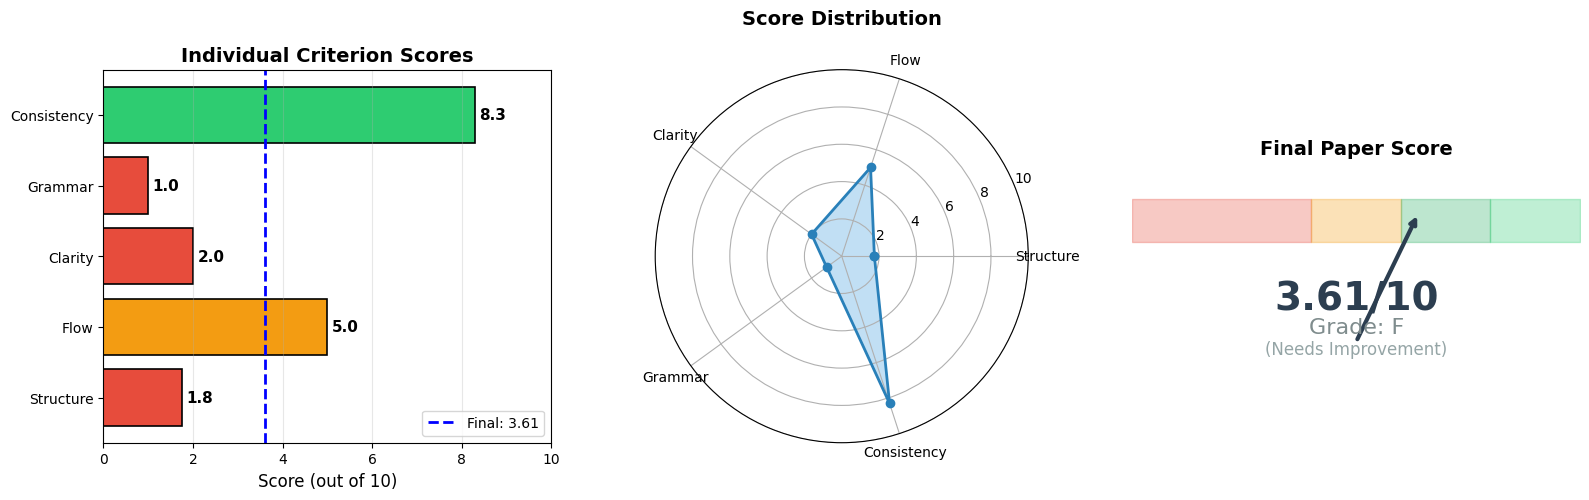

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# =============================================================================
# SCORE PAPER QUALITY
# =============================================================================

def score_paper(pipeline_results, custom_weights=None):
    """
    Complete function to score a paper and display all results.

    Args:
        pipeline_results: Output from the unified pipeline
        custom_weights: Optional dict to adjust scoring weights
                       e.g., {'grammar_quality': 2.0} to weight grammar higher

    Returns:
        PaperQualityScorer instance with all scores
    """
    if pipeline_results is None:
        print("No pipeline results provided. Run the pipeline first.")
        return None

    # Initialize scorer with optional custom weights
    scorer = PaperQualityScorer(weights=custom_weights)

    # Calculate all scores
    print("Calculating paper quality scores...")
    scores, details = scorer.calculate_all_scores(pipeline_results)

    # Print text report
    print(scorer.generate_report())

    # Display detailed breakdown
    display_detailed_scores(scorer)

    # Visualize scores
    visualize_scores(scorer)

    return scorer

# Run scoring on pipeline results
if 'pipeline_results' in globals() and pipeline_results is not None:
    print("Scoring pipeline results...")
    scored_paper = score_paper(pipeline_results)
elif 'existing_ocr_results' in globals() and existing_ocr_results is not None:
    print("Scoring existing OCR results...")
    scored_paper = score_paper(existing_ocr_results)
else:
    print("⚠ No pipeline results found. Run the pipeline first (Phase 7), then run this cell.")
    scored_paper = None


## **4. Custom Weighted Scoring & Recommendations**

You can customize the importance of each criterion by adjusting weights.


In [19]:
# =============================================================================
# CUSTOM WEIGHTED SCORING
# =============================================================================

# Example: Weight grammar more heavily for conference submissions
conference_weights = {
    'structure': 1.5,           # Structure is important
    'section_order': 1.0,       # Standard weight
    'classification_confidence': 0.8,  # Less important
    'grammar_quality': 2.0,     # Grammar is crucial
    'consistency': 1.5          # Consistency matters
}

# Example: Weight structure more heavily for thesis evaluation
thesis_weights = {
    'structure': 2.0,           # Thesis needs good structure
    'section_order': 1.5,       # Flow is important
    'classification_confidence': 1.0,
    'grammar_quality': 1.5,
    'consistency': 1.0
}

def generate_improvement_recommendations(scorer):
    """
    Generate specific recommendations based on low-scoring areas.
    """
    if not scorer.scores:
        return "No scores available for recommendations."

    recommendations = []
    recommendations.append("\n" + "=" * 70)
    recommendations.append("IMPROVEMENT RECOMMENDATIONS")
    recommendations.append("=" * 70)

    # Structure recommendations
    if scorer.scores.get('structure', 10) < 7:
        details = scorer.details.get('structure', {})
        missing = details.get('essential_missing', [])
        if missing:
            recommendations.append(f"\nStructure: Add missing sections: {', '.join(missing)}")
        recommendations.append("   • Ensure all standard academic sections are present")
        recommendations.append("   • Consider adding Related Work or Appendix sections")

    # Order recommendations
    if scorer.scores.get('section_order', 10) < 7:
        details = scorer.details.get('section_order', {})
        if not details.get('starts_with_intro', True):
            recommendations.append("\nFlow: Start your paper with an Introduction section")
        if not details.get('ends_with_conclusion', True):
            recommendations.append("   • End with a Conclusion or Discussion section")
        recommendations.append("   • Follow standard academic paper structure")

    # Clarity recommendations
    if scorer.scores.get('classification_confidence', 10) < 7:
        recommendations.append("\nClarity: Improve section definitions")
        recommendations.append("   • Use clear, descriptive section headings")
        recommendations.append("   • Ensure each section focuses on its specific topic")
        recommendations.append("   • Add transition sentences between sections")

    # Grammar recommendations
    if scorer.scores.get('grammar_quality', 10) < 7:
        recommendations.append("\nGrammar: Improve writing quality")
        recommendations.append("   • Consider professional proofreading")
        recommendations.append("   • Use grammar checking tools (Grammarly, etc.)")
        recommendations.append("   • Review academic writing guidelines")

    # Consistency recommendations
    if scorer.scores.get('consistency', 10) < 7:
        details = scorer.details.get('consistency', {})
        if details.get('refutes', 0) > 0:
            recommendations.append("\nConsistency: Address contradictory statements")
            recommendations.append("   • Review claims made in different sections")
            recommendations.append("   • Ensure terminology is used consistently")
        recommendations.append("   • Cross-check facts and figures throughout the paper")

    # Overall recommendation
    final_score = scorer.scores.get('final', 0)
    if final_score >= 8:
        recommendations.append("\nOverall: Your paper is well-written! Minor improvements may help.")
    elif final_score >= 6:
        recommendations.append("\nOverall: Good foundation, but several areas need attention.")
    else:
        recommendations.append("\nOverall: Significant revisions recommended before submission.")

    recommendations.append("\n" + "=" * 70)

    return "\n".join(recommendations)

# Display recommendations if scorer exists
if 'scored_paper' in globals() and scored_paper is not None:
    print(generate_improvement_recommendations(scored_paper))
else:
    print("Run the scoring cell above first to get recommendations.")



IMPROVEMENT RECOMMENDATIONS

Structure: Add missing sections: Experiments, Introduction, Conclusion, Methodology
   • Ensure all standard academic sections are present
   • Consider adding Related Work or Appendix sections
   • Follow standard academic paper structure

Clarity: Improve section definitions
   • Use clear, descriptive section headings
   • Ensure each section focuses on its specific topic
   • Add transition sentences between sections

Grammar: Improve writing quality
   • Consider professional proofreading
   • Use grammar checking tools (Grammarly, etc.)
   • Review academic writing guidelines

Overall: Significant revisions recommended before submission.



## **5. Scoring System Summary**

### **How the Final Score is Calculated:**

```
Final Score = (Score₁ × W₁ + Score₂ × W₂ + Score₃ × W₃ + Score₄ × W₄ + Score₅ × W₅) / (W₁ + W₂ + W₃ + W₄ + W₅)
```

Where:
- **Score₁**: Structure & Completeness (from Phase 3 classification)
- **Score₂**: Section Order & Flow (from Phase 3 classification)
- **Score₃**: Section Clarity (from Phase 3 confidence scores)
- **Score₄**: Grammar Quality (from Phase 5 correction analysis)
- **Score₅**: Internal Consistency (from Phase 6 fact-checking)

### **Grade Scale:**

| Score Range | Grade | Description |
|------------|-------|-------------|
| 9.0 - 10.0 | A+ | Excellent |
| 8.0 - 8.9 | A | Very Good |
| 7.0 - 7.9 | B+ | Good |
| 6.0 - 6.9 | B | Above Average |
| 5.0 - 5.9 | C | Average |
| 4.0 - 4.9 | D | Below Average |
| 0.0 - 3.9 | F | Needs Improvement |

### **Integration with Pipeline:**

The scoring system is automatically run after the unified pipeline completes, providing instant feedback on paper quality.
